# Exercice: agrégation
Nous verrons ici comment agréger une table input-output. Différentes raisons peuvent pousser à agréger/désagréger une table existante, notamment afin de la faire correspondre à un jeu de données externe (avec une classification différente) ou encore d'effectuer les calculs plus rapidement (la complexité augmente avec le carré de la résolution).

In [3]:
import pymrio as mr   # manipulation des données input-output
import pandas as pd   # manipulation de tables et jeux de données
import numpy as np    # opérations communes
import seaborn as sns # production de figures, add-on à matplotlib
import matplotlib.pyplot as plt # production de figures
import os # opérations sur le système de fichiers

In [4]:
# Si vous voulez enregistrer/charger rapidement
import pickle

In [5]:
year = 2019
EXIOBASE_PATH = '../EXIOBASE/' # ne pas hésiter à changer

In [6]:
# Chargement rapide des données IO
with open(EXIOBASE_PATH + f'IOT_{year}_ixi.pickle', 'rb') as handle:
    io = pickle.load(handle)

## Agrégation des secteurs

In [7]:
# Chargement du fichier de correspondance pour les secteurs
sec_agg_raw = pd.read_excel('data/NACE2full_EXIOBASEp.xlsx')

In [8]:
sec_agg_raw_lvl1 = sec_agg_raw[sec_agg_raw['Level']==1].drop(['Unnamed: 2','Unnamed: 3','Level'], axis=1)

sec_agg = sec_agg_raw_lvl1.set_index('Code').stack().droplevel(1)

sec_agg_dict = {v:k for k,v in sec_agg.items()}

# Les libellés ne sont pas exactement les mêmes dans le fichier importé...
sec_agg_dict['Manure treatment (conventional), storage and land application'] = sec_agg_dict['Manure treatment (conventional) and land application']
sec_agg_dict['Manure treatment (biogas), storage and land application'] = sec_agg_dict['Manure treatment (biogas) and land application']
sec_agg_dict['Re-processing of secondary wood material into new wood material'] = sec_agg_dict['Woodwaste']
sec_agg_dict['Re-processing of secondary paper into new pulp'] = sec_agg_dict['Recycling of waste paper']
sec_agg_dict['Re-processing of secondary plastic into new plastic'] = sec_agg_dict['Recycling of plastics waste']
sec_agg_dict['Re-processing of secondary glass into new glass'] = sec_agg_dict['Recycling of waste and scrap']
sec_agg_dict['Re-processing of secondary aluminium into new aluminium'] = sec_agg_dict['Recycling of aluminium waste']
sec_agg_dict['Re-processing of secondary copper into new copper'] = sec_agg_dict['Recycling of copper waste']
sec_agg_dict['Re-processing of secondary lead into new lead, zinc and tin'] = sec_agg_dict['Recycling of lead, zinc and tin waste']
sec_agg_dict['Re-processing of secondary other non-ferrous metals into new other non-ferrous metals'] = sec_agg_dict['Recycling of aluminium waste']
sec_agg_dict['Re-processing of secondary plastic into new plastic'] = sec_agg_dict['Recycling of waste and scrap']
sec_agg_dict['Re-processing of secondary preciuos metals into new preciuos metals'] = sec_agg_dict['Recycling of pecious metals waste']
sec_agg_dict['Re-processing of secondary steel into new steel'] = sec_agg_dict['Recycling of steel scrap']
sec_agg_dict['Re-processing of secondary construction material into aggregates'] = sec_agg_dict['Recycling of construction waste']
sec_agg_dict['Recycling of bottles by direct reuse'] = sec_agg_dict['Glass bottles directly reused']
sec_agg_dict['Re-processing of ash into clinker'] = sec_agg_dict['Glass bottles directly reused']
sec_agg_dict['Biogasification of food waste, incl. land application'] = sec_agg_dict['Biogasification of food waste']
sec_agg_dict['Biogasification of paper, incl. land application'] = sec_agg_dict['Biogasification of paper']
sec_agg_dict['Biogasification of sewage slugde, incl. land application'] = sec_agg_dict['Biogasification of sewage slugde']
sec_agg_dict['Composting of food waste, incl. land application'] = sec_agg_dict['Composting of food waste']
sec_agg_dict['Composting of paper and wood, incl. land application'] = sec_agg_dict['Composting of paper and wood']

# Ces trois là sont des approximations, mais la catégorie principale est la même (NACE "E")
sec_agg_dict['Landfill of waste: Inert/metal/hazardous'] = sec_agg_dict['Incineration of waste: Metals and Inert materials']
sec_agg_dict['Landfill of waste: Textiles'] = sec_agg_dict['Incineration of waste: Textiles']
sec_agg_dict['Landfill of waste: Wood'] = sec_agg_dict['Incineration of waste: Wood']


## Agrégation des régions

In [9]:
# Paramètres de l'agrégation pour les pays
reg_agg_dict = dict(zip(io.get_regions(), ['EU28'] * 28 + ['RoW'] * 21))

for c in ['LU', 'BE', 'FR', 'DE', 'NL', 'CH']:
    reg_agg_dict[c] = c

In [10]:
io_LU = io.copy()

io_LU.rename_sectors(sec_agg_dict).aggregate_duplicates()
io_LU.rename_regions(reg_agg_dict).aggregate_duplicates()

In [11]:
# On recalcule le tout
io_LU.calc_all()

In [12]:
io_LU.A.shape

(168, 168)

Nous avons à présent une classification de 8 régions × 21 secteurs = 168, ce qui rendra les calculs plus simples.

In [13]:
# Il reste à remplacer les noms des catégories
nace2_labels = pd.read_excel('data/NACE2_labels.xlsx', index_col=0)

In [14]:
io_LU.rename_sectors(nace2_labels.to_dict()['Label'])

In [15]:
# Et on sauvegarde le tout dans un fichier Excel
writer = pd.ExcelWriter('excel/io_LU_2019.xlsx', engine='xlsxwriter')

io_LU.Z.to_excel(writer, sheet_name='Z')
io_LU.x.to_excel(writer, sheet_name='x')
io_LU.Y.to_excel(writer, sheet_name='Y')
io_LU.A.to_excel(writer, sheet_name='A')
io_LU.L.to_excel(writer, sheet_name='L')

io_LU.impacts.F.to_excel(writer, sheet_name='F_impacts')
io_LU.satellite.F.to_excel(writer, sheet_name='F_satellite')

io_LU.impacts.S.to_excel(writer, sheet_name='S_impacts')
io_LU.satellite.S.to_excel(writer, sheet_name='S_satellite')

writer.close()

## Empreinte du Luxembourg

Regardons l'empreinte carbone avec l'indicateur GWP100.

In [16]:
ind = 'GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'

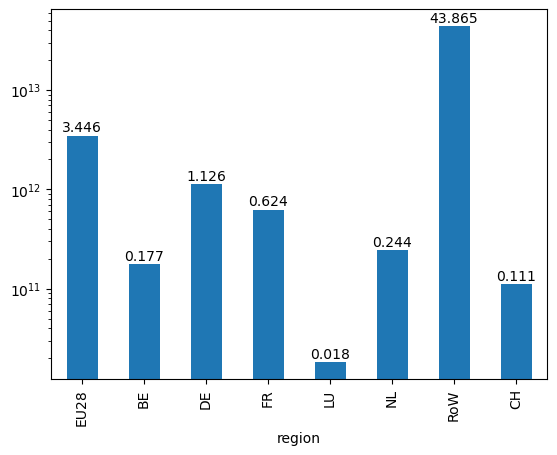

In [20]:
# Comparaison avec les autres régions, total
GWP = io_LU.impacts.D_cba_reg.loc[ind]
scale = 1e12
ax = GWP.plot.bar()
ax.set_yscale('log')
for i,row in enumerate(GWP.items()):
    ax.annotate(f'{row[1]/scale:.3f}',(i,row[1]*1.1), ha='center')

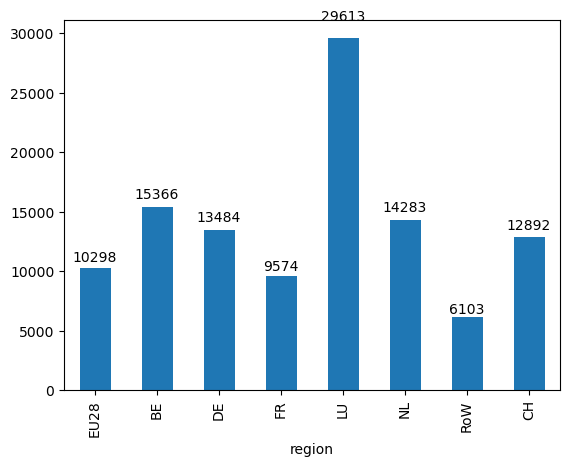

In [18]:
# Comparaison avec les autres régions, per capita
GWP = io_LU.impacts.D_cba_cap.loc[ind]
scale = 1
ax = GWP.plot.bar()
for i,row in enumerate(GWP.items()):
    ax.annotate(f'{row[1]/scale:.0f}',(i,row[1]*1.05), ha='center')

Calculons maintenant les interactions entre pays dues à la demande finale du Luxembourg. La formule pour le calcul qui nous intéresse est $$GHG_{cons pro LU}=\widehat{S_{GWP100}}L\widehat{y_{LU}}$$

In [21]:
Y_LU = io_LU.Y['LU'].sum(1)

In [25]:
GHG_cons_pro_LU = io_LU.L.multiply(io_LU.impacts.S.loc[ind],axis=0).multiply(Y_LU)

In [26]:
GHG_cons_pro_LU.s

region                                                                                 EU28  \
sector                                                    Agriculture, forestry and fishing   
region sector                                                                                 
EU28   Agriculture, forestry and fishing                                       1.464595e+08   
       Mining and quarrying                                                    1.137053e+06   
       Manufacturing                                                           3.089708e+06   
       Information and communication                                           6.876538e+04   
       Water supply; sewerage, waste management and re...                      1.700635e+06   
...                                                                                     ...   
CH     Public administration and defence; compulsory s...                      3.688895e+01   
       Human health and social work activities                                 5.660494e+00   
       Arts, entertainment and recreation                                      3.531477e+01   
       Activities of households as employers; undiffer...                      2.144241e+00   
       Activities of extraterritorial organisations an...                      0.000000e+00   

region                                                                          \
sector                                                    Mining and quarrying   
region sector                                                                    
EU28   Agriculture, forestry and fishing                          6.496405e+04   
       Mining and quarrying                                       1.045773e+07   
       Manufacturing                                              1.335051e+05   
       Information and communication                              6.285538e+03   
       Water supply; sewerage, waste management and re...         1.074964e+05   
...                                                                        ...   
CH     Public administration and defence; compulsory s...         2.200553e+00   
       Human health and social work activities                    2.853113e-01   
       Arts, entertainment and recreation                         2.510550e+00   
       Activities of households as employers; undiffer...         3.039214e-01   
       Activities of extraterritorial organisations an...         0.000000e+00   

region                                                                   \
sector                                                    Manufacturing   
region sector                                                             
EU28   Agriculture, forestry and fishing                   1.897609e+08   
       Mining and quarrying                                7.415865e+07   
       Manufacturing                                       4.580176e+08   
       Information and communication                       2.777122e+06   
       Water supply; sewerage, waste management and re...  8.587124e+07   
...                                                                 ...   
CH     Public administration and defence; compulsory s...  1.725245e+03   
       Human health and social work activities             2.309034e+02   
       Arts, entertainment and recreation                  1.827073e+03   
       Activities of households as employers; undiffer...  4.412147e+01   
       Activities of extraterritorial organisations an...  0.000000e+00   

region                                                                                   \
sector                                                    Information and communication   
region sector                                                                             
EU28   Agriculture, forestry and fishing                                   1.092471e+05   
       Mining and quarrying                                                1.018221e+05   
       Manufac

In [26]:
GHG_cons_pro_LU.loc[:,('TOTAL','TOTAL')] = GHG_cons_pro_LU.sum(1)
GHG_cons_pro_LU.loc[('TOTAL','TOTAL'),:] = GHG_cons_pro_LU.sum(0)

C:\Users\Gibon\AppData\Local\Temp\ipykernel_17552\2833914340.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  GHG_snap = GHG_cons_pro_LU.sort_values(('TOTAL','TOTAL'),axis=1,ascending=False).sort_values(('TOTAL','TOTAL'),ascending=False).iloc[:50,:20].drop('TOTAL').drop('TOTAL',axis=1)*1e-6


<Axes: xlabel='region-sector', ylabel='region-sector'>

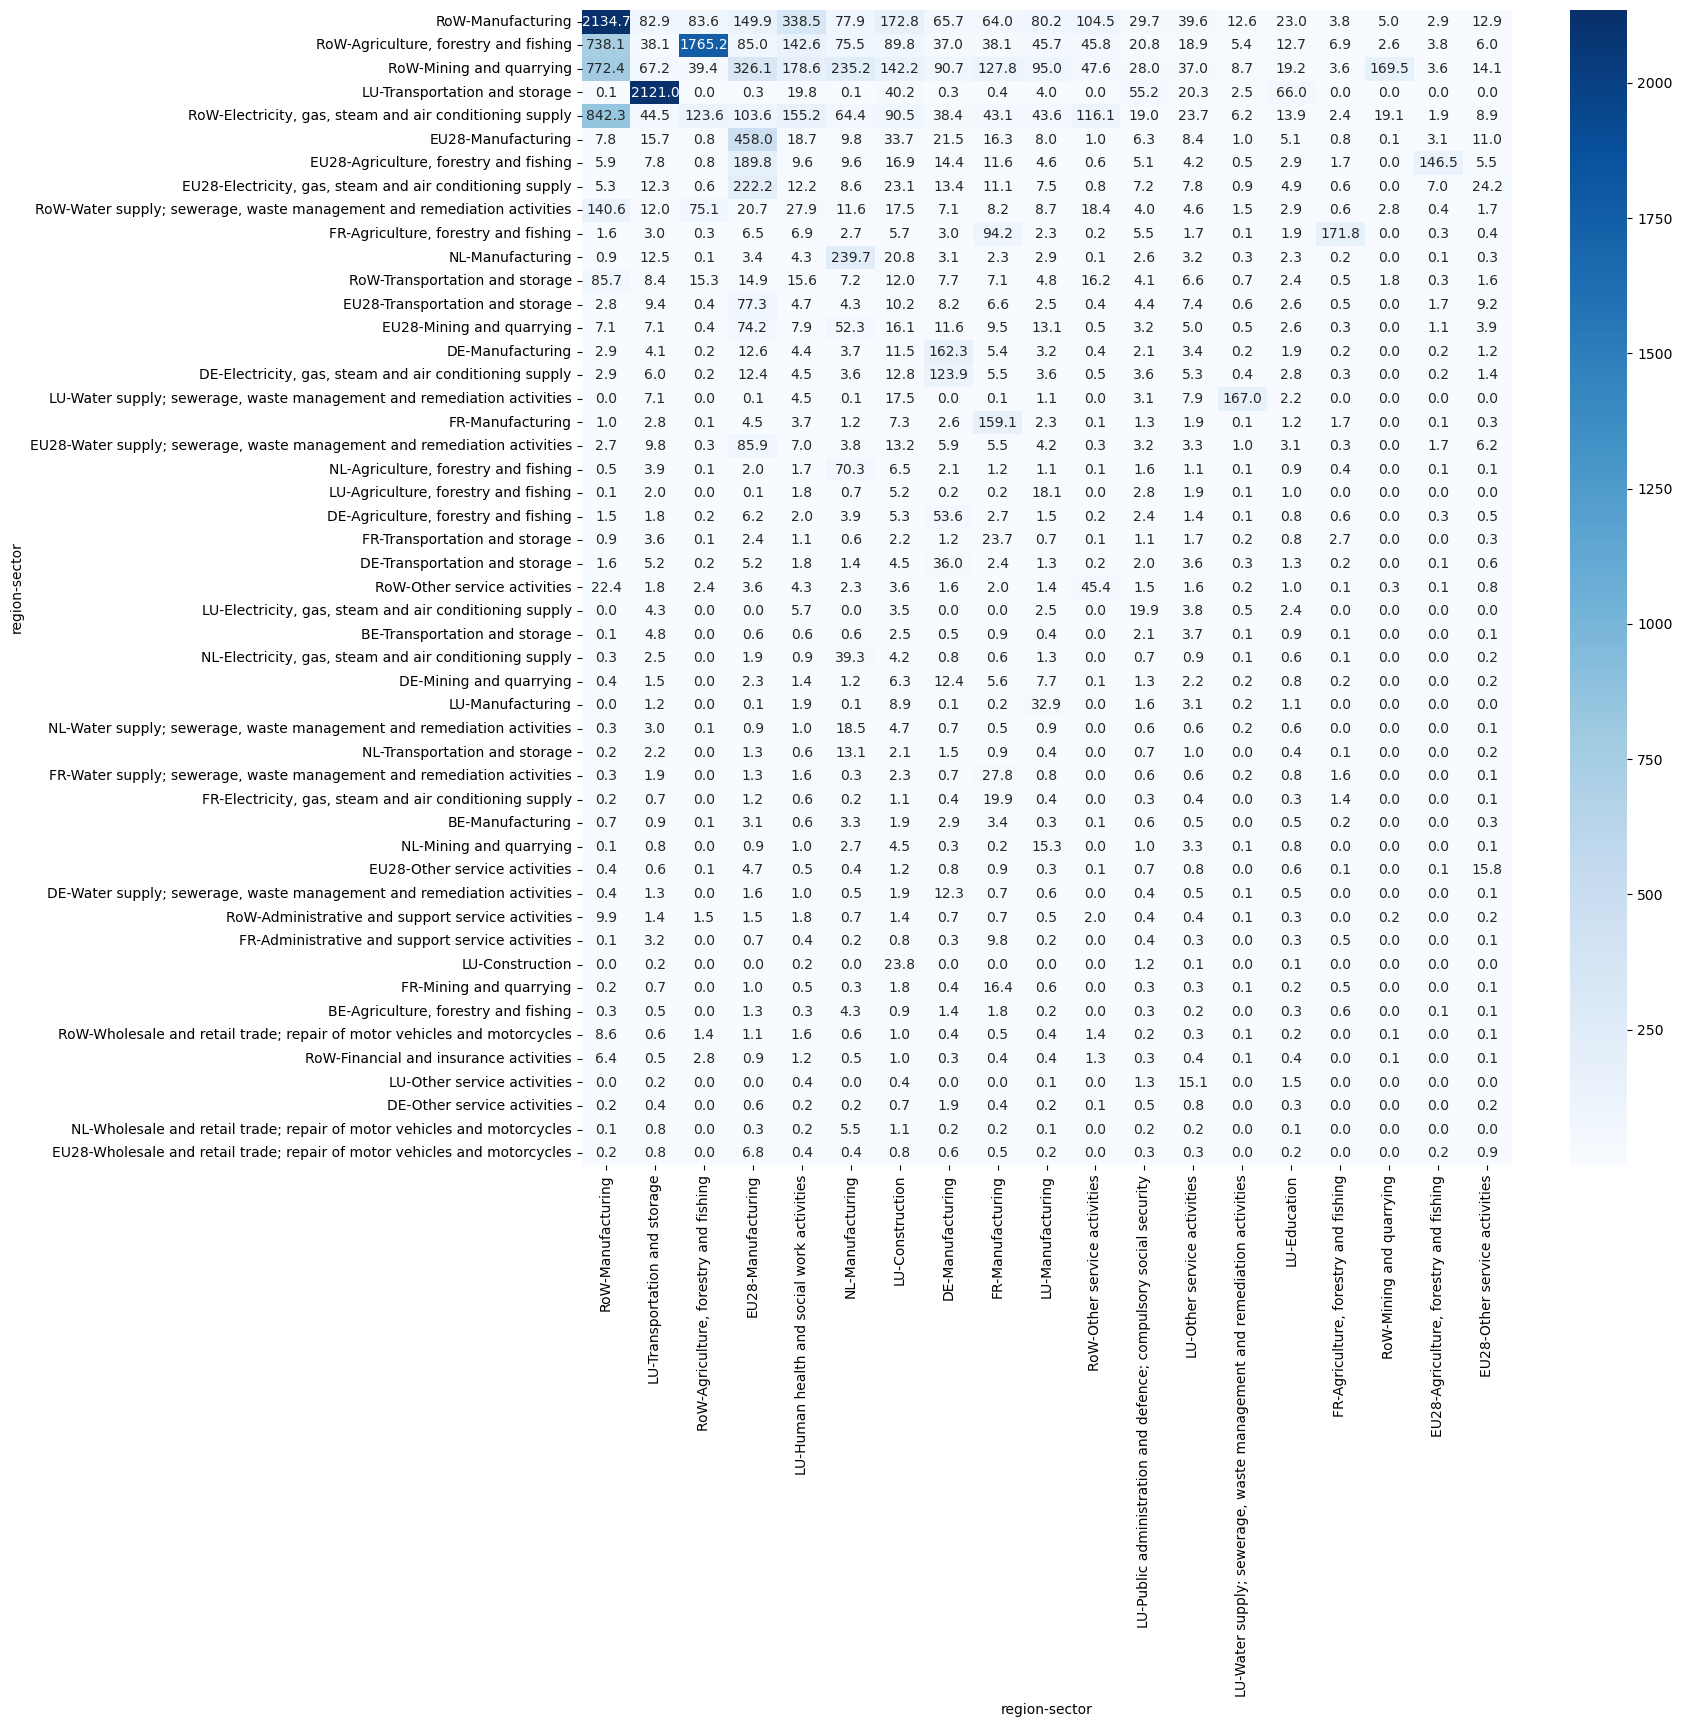

In [31]:
GHG_snap = GHG_cons_pro_LU.sort_values(('TOTAL','TOTAL'),axis=1,ascending=False).sort_values(('TOTAL','TOTAL'),ascending=False).iloc[:50,:20].drop('TOTAL').drop('TOTAL',axis=1)*1e-6
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(GHG_snap, annot=True,
#             norm=matplotlib.colors.LogNorm(vmin=1e-6,
#                                            vmax=GHG_snap.max().max()),
            cmap='Blues', fmt='.1f')

In [42]:
pd.DataFrame(np.diag(io_LU.impacts.F_Y.sum(level='region',axis=1).loc[ind]),
                             index=GHG_cons_pro_LU.index,
                             columns=GHG_cons_pro_LU.columns)

C:\Users\Gibon\AppData\Local\Temp\ipykernel_17552\2881526549.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  np.diag(io_LU.impacts.F_Y.sum(level='region',axis=1).loc[ind])


array([[4.33172231e+11, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.78447543e+10, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.52631094e+11, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.32966680e+10,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.17734261e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.60129915e+10, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.77709295e+12, 0.

In [40]:
GHG_cons_pro_LU_FD=pd.DataFrame(np.diag(io_LU.impacts.F_Y.sum(level='region',axis=1).loc[ind]),
                             index=GHG_cons_pro_LU.index,
                             columns=GHG_cons_pro_LU.columns)
GHG_cons_pro_LU_tot=GHG_cons_pro_LU+GHG_cons_pro_LU_FD

C:\Users\Gibon\AppData\Local\Temp\ipykernel_17552\616135564.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  GHG_cons_pro_LU_FD=pd.DataFrame(np.diag(io_LU.impacts.F_Y.sum(level='region',axis=1).loc[ind]),


ValueError: Shape of passed values is (8, 8), indices imply (169, 169)

## Part des transactions liée à la demande du Luxembourg

In [ ]:
Y_LU = io_LU.Y.copy()

for r in io_LU.get_regions():
    if r != 'LU':
        Y_LU[r] = 0

In [32]:
x_LU = io_LU.L.dot(io_LU.Y['LU']).sum(axis=1)
x_LU

region  sector                                                                                                                   
EU28    Agriculture, forestry and fishing                                                                                             421.459020
        Mining and quarrying                                                                                                          220.292784
        Manufacturing                                                                                                                6025.857688
        Information and communication                                                                                                 302.837572
        Water supply; sewerage, waste management and remediation activities                                                           214.439500
                                                                                                                                        ...     


In [33]:
Z_LU = io_LU.A.mul(x_LU, axis=1)
Z_LU.sum().sum()

46715.618258815

<Axes: xlabel='region-sector', ylabel='region-sector'>

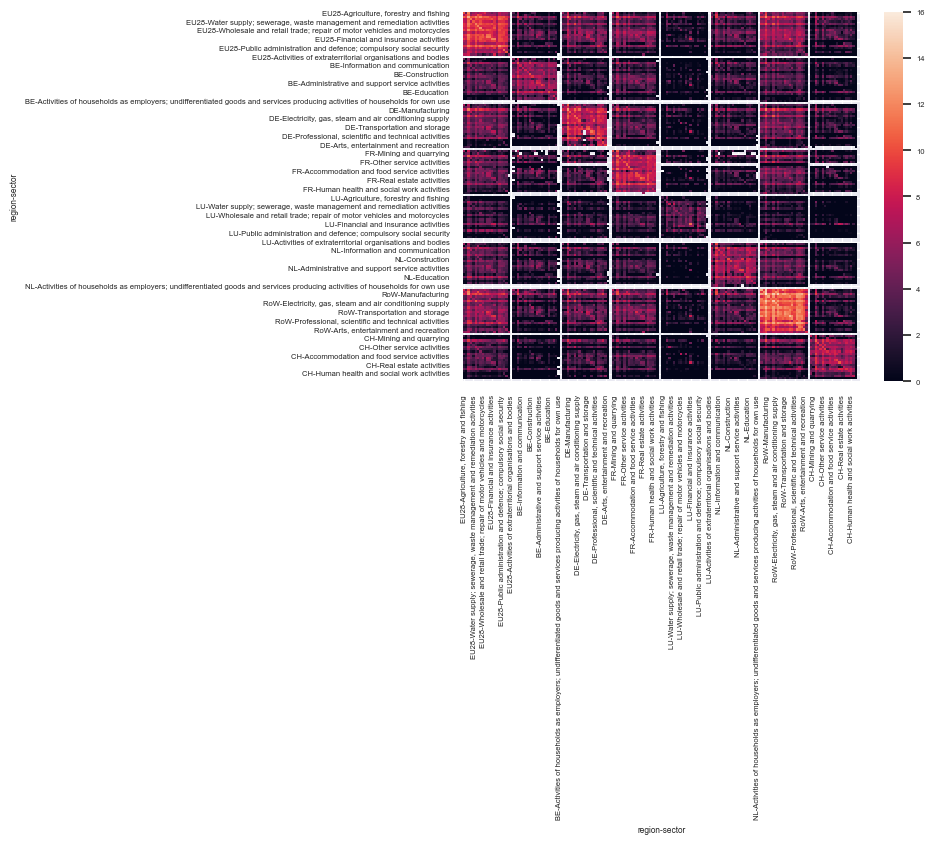

In [36]:
# fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=0.5)
sns.heatmap(np.log(io_LU.Z), vmin=0, vmax=16)

<Axes: xlabel='region-sector', ylabel='region-sector'>

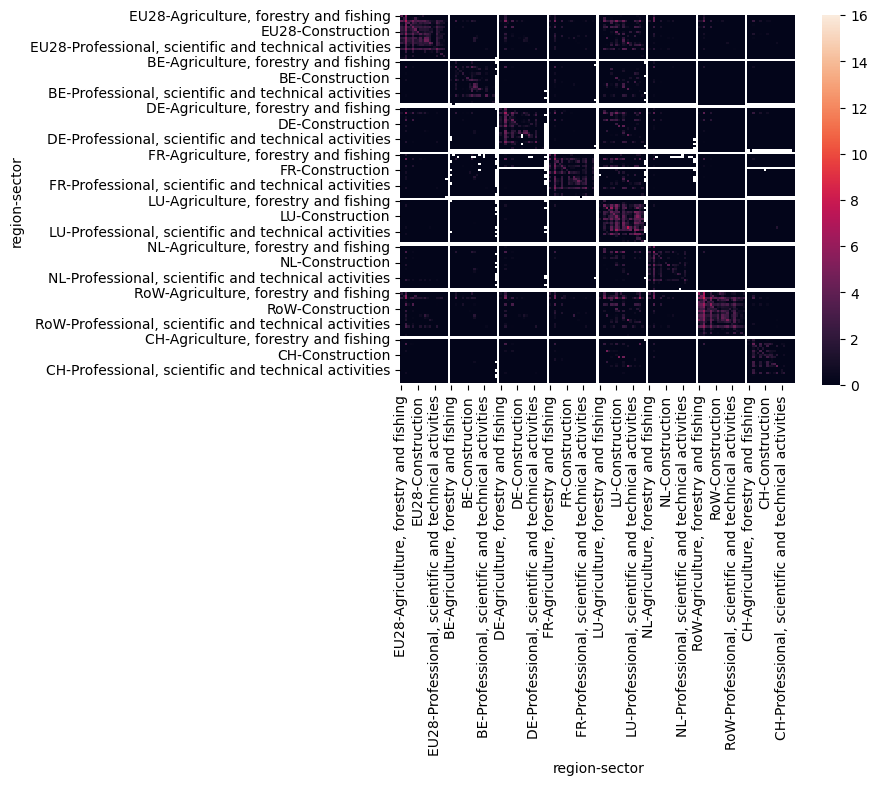

In [35]:
sns.heatmap(np.log(Z_LU), vmin=0, vmax=16)